In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import tan, arctan, cos, sin, pi
from numpy.random import randn,rand
import rospy
data = np.load('inner_track.npy')

In [2]:
plt.plot(data[0],data[1],'o')

In [3]:
class Simulator(object):
    """ Object collecting GPS measurement data
    Attributes:
        Model params:
            1.L_f 2.L_r 3.m(car mass) 3.I_z(car inertial) 4.c_f(equivalent drag coefficient)
        States:
            1.x 2.y 3.vx 4.vy 5.ax 6.ay 7.psiDot
        States history:
            1.x_his 2.y_his 3.vx_his 4.vy_his 5.ax_his 6.ay_his 7.psiDot_his
        Simulator sampling time:
            1. dt
        Time stamp:
            1. time_his
    Methods:
        f(u):
            System model used to update the states
        pacejka(ang):
            Pacejka lateral tire modeling
    """
    def __init__(self):

        self.L_f    = 0.125
        self.L_r    = 0.125
        self.m      = 1.98
        self.I_z    = 0.03
        self.c_f    = 68

        self.B = rospy.get_param("simulator/B")
        self.C = rospy.get_param("simulator/C")
        self.mu= 0.05
        self.g = 9.81

        self.x      = 0.01
        self.y      = 0.0
        self.vx     = 0
        self.vy     = 0.0
        self.ax     = 0.0
        self.ay     = 0.0

        self.yaw    = 0.0

        self.psiDot = 0.0

        self.x_his      = []
        self.y_his      = []
        self.vx_his     = []
        self.vy_his     = []
        self.ax_his     = []
        self.ay_his     = []
        self.psiDot_his = []

        self.dt         = rospy.get_param("simulator/dt")
        self.rate       = rospy.Rate(1.0/self.dt)
        self.time_his   = []


    def f(self,u):
        a_F = 0.0
        a_R = 0.0

        if abs(self.vx) > 0.2:
            a_F = u[1] - arctan((self.vy + self.L_f*self.psiDot)/abs(self.vx))
            a_R = arctan((- self.vy + self.L_r*self.psiDot)/abs(self.vx))

        # FyF = self.pacejka(a_F)
        # FyR = self.pacejka(a_R)
        FyF = 60*a_F
        FyR = 60*a_R


        if abs(a_F) > 30.0/180.0*pi or abs(a_R) > 30.0/180.0*pi:
            print ("WARNING: Large slip angles in simulation")

        x   = self.x
        y   = self.y
        ax  = self.ax
        ay  = self.ay
        vx  = self.vx
        vy  = self.vy
        yaw = self.yaw
        psiDot = self.psiDot
                
        self.x      += self.dt*(cos(yaw)*vx - sin(yaw)*vy)
        self.y      += self.dt*(sin(yaw)*vx + cos(yaw)*vy)
        self.vx     += self.dt*(ax + psiDot*vy)
        self.vy     += self.dt*(ay - psiDot*vx)
        self.ax      = u[0] - self.mu*vx - FyF/self.m*sin(u[1])
        self.ay      = 1.0/self.m*(FyF*cos(u[1])+FyR)
        self.yaw    += self.dt*(psiDot)                                        
        self.psiDot += self.dt*(1.0/self.I_z*(self.L_f*FyF*cos(u[1]) - self.L_r*FyR))

        self.vx = abs(self.vx)
    

    def pacejka(self,ang):
        D = self.c_f*self.m*self.g/2    # Friction force/2
        Stiffness_Force = D*sin(self.C*arctan(self.B*ang))
        return Stiffness_Force

    def saveHistory(self):
        self.x_his.append(self.x)
        self.y_his.append(self.y)
        self.vx_his.append(self.vx)
        self.vy_his.append(self.vy)
        self.ax_his.append(self.ax)
        self.ay_his.append(self.ay)
        self.psiDot_his.append(self.psiDot)
        self.time_his.append(rospy.get_rostime().to_sec()) 



In [10]:
cos(90*3.14/180)

0.0007963267107332633

In [4]:
sim = Simulator()
steer_in = np.linspace(0,0.249,500)
acc_in = np.linspace(0,1,500)
data = []
for i,(acc,steer) in enumerate(zip(acc_in,steer_in)):

        sim.f([acc,steer])
        print ("acc,steer",acc,steer)
        data.append([sim.x,sim.y])
data = np.dstack(data)
plt.plot(data[0][0],data[0][1]) 
#     print ('sim.vx',sim.vx,'sim.vy',sim.vy,'sim.x',sim.x,'sim.y',sim.y)

KeyError: 'simulator/B'

In [241]:
arctan(((data[0][1][-2]-data[0][1][-1])/(data[0][0][-2]-data[0][0][-1])))*180/3.14

46.53570313170519

In [78]:
data[0][0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.26262626e-06,
       5.05050505e-06, 1.26262626e-05, 2.52525253e-05, 4.41919192e-05,
       7.07070707e-05, 1.06060606e-04, 1.51515152e-04, 2.08333333e-04,
       2.77777778e-04, 3.61111111e-04, 4.59595960e-04, 5.74494949e-04,
       7.07070707e-04, 8.58585859e-04, 1.03030303e-03, 1.22348485e-03,
       1.43939394e-03, 1.67929293e-03, 1.94444444e-03, 2.23611111e-03,
       2.55555556e-03, 2.90404040e-03, 3.28282828e-03, 3.69318182e-03,
       4.13636364e-03, 4.61363636e-03, 5.12626263e-03, 5.67550505e-03,
       6.26262626e-03, 6.88888889e-03, 7.55555556e-03, 8.26388889e-03,
       9.01515152e-03, 9.81060606e-03, 1.06515152e-02, 1.15391414e-02,
       1.24747475e-02, 1.34595960e-02, 1.44949495e-02, 1.55820707e-02,
       1.67222222e-02, 1.79166667e-02, 1.91666667e-02, 2.04734848e-02,
       2.18383838e-02, 2.32626263e-02, 2.47474747e-02, 2.62941919e-02,
       2.79040404e-02, 2.95782828e-02, 3.13181818e-02, 3.31250000e-02,
      

In [101]:
tan(0.15)*180/3.14

8.66380230907424

In [5]:
def kin_sim(z,u,dt):
        # get states / inputs
        x       = z[0]
        y       = z[1]
        psi     = z[2]
        v       = z[3]
        d_f     = u[0]
        a       = u[1]

        # extract parameters
        L_a = 0.125
        L_b = 0.125

        # compute slip angle
        bta         = arctan( L_a / (L_a + L_b) * tan(d_f) )

        # compute next state
        x_next      = x + dt*( v*cos(psi + bta) )
        y_next      = y + dt*( v*sin(psi + bta) )
        psi_next    = psi + dt*v/L_b*sin(bta)
        v_next      = v + dt*a

        return [x_next, y_next, psi_next, v_next]

    
steer_in = np.linspace(0,0.254,50)
acc_in = np.linspace(0,1,50)
x_next =0
y_next =0 
psi_next = 0 
v_next = 0
dt = 0.1
z = [x_next, y_next, psi_next, v_next]
data = []
for i,(acc,steer) in enumerate(zip(acc_in,steer_in)):
        u = [steer,acc]
        z = kin_sim(z,u,dt)
        data.append(z)
data = np.dstack(data)
plt.plot(data[0][0],data[0][1])   
    

In [6]:
max_acceleration=3.0 # max m/s2
max_angle_steering=0.249 #Absolut value
actions=[]
for i in np.linspace(-2,max_acceleration,20): # 5 values of acceleration
    for j in np.linspace(-max_angle_steering,max_angle_steering,7): # / values of angle steering
        actions.append([round(i,1),round(j,3)])


In [25]:
actions

[[-2.0, -0.249],
 [-2.0, -0.166],
 [-2.0, -0.083],
 [-2.0, 0.0],
 [-2.0, 0.083],
 [-2.0, 0.166],
 [-2.0, 0.249],
 [-1.7, -0.249],
 [-1.7, -0.166],
 [-1.7, -0.083],
 [-1.7, 0.0],
 [-1.7, 0.083],
 [-1.7, 0.166],
 [-1.7, 0.249],
 [-1.5, -0.249],
 [-1.5, -0.166],
 [-1.5, -0.083],
 [-1.5, 0.0],
 [-1.5, 0.083],
 [-1.5, 0.166],
 [-1.5, 0.249],
 [-1.2, -0.249],
 [-1.2, -0.166],
 [-1.2, -0.083],
 [-1.2, 0.0],
 [-1.2, 0.083],
 [-1.2, 0.166],
 [-1.2, 0.249],
 [-0.9, -0.249],
 [-0.9, -0.166],
 [-0.9, -0.083],
 [-0.9, 0.0],
 [-0.9, 0.083],
 [-0.9, 0.166],
 [-0.9, 0.249],
 [-0.7, -0.249],
 [-0.7, -0.166],
 [-0.7, -0.083],
 [-0.7, 0.0],
 [-0.7, 0.083],
 [-0.7, 0.166],
 [-0.7, 0.249],
 [-0.4, -0.249],
 [-0.4, -0.166],
 [-0.4, -0.083],
 [-0.4, 0.0],
 [-0.4, 0.083],
 [-0.4, 0.166],
 [-0.4, 0.249],
 [-0.2, -0.249],
 [-0.2, -0.166],
 [-0.2, -0.083],
 [-0.2, 0.0],
 [-0.2, 0.083],
 [-0.2, 0.166],
 [-0.2, 0.249],
 [0.1, -0.249],
 [0.1, -0.166],
 [0.1, -0.083],
 [0.1, 0.0],
 [0.1, 0.083],
 [0.1, 0.166],
 [0.1

In [48]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

x = 0
y = 0
h= 1
w = 1
verts1 = [
   (x, y),  # left, bottom
   (x, h),  # left, top
   (w, h),  # right, top
   (w, y),  # right, bottom
   (0., 0.),  # ignored
]


x = 2
y = 0
h= 1
w = 1
verts2 = [
   (x, y),  # left, bottom
   (x, h),  # left, top
   (w, h),  # right, top
   (w, y),  # right, bottom
   (0., 0.),  # ignored
]


x = 0
y = 2
h= 1
w = 2
verts3 = [
   (x, y),  # left, bottom
   (x, h),  # left, top
   (w, h),  # right, top
   (w, y),  # right, bottom
   (0., 0.),  # ignored
]


codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

path1 = Path(verts1, codes)
path2 = Path(verts2, codes)
path3 = Path(verts3, codes)

fig, ax = plt.subplots()
patch1 = patches.PathPatch(path1, facecolor=(1, 0, 0),lw=2)
ax.add_patch(patch1)

patch2 = patches.PathPatch(path2, facecolor=(1, 0, 1), lw=2)
ax.add_patch(patch2)

patch3 = patches.PathPatch(path3, facecolor=(0, 0, 1), lw=2)
ax.add_patch(patch3)


ax.set_xlim(-2, 8)
ax.set_ylim(-2,8)
plt.show()

track selected L_shape


ValueError: Invalid RGBA argument: 'G'

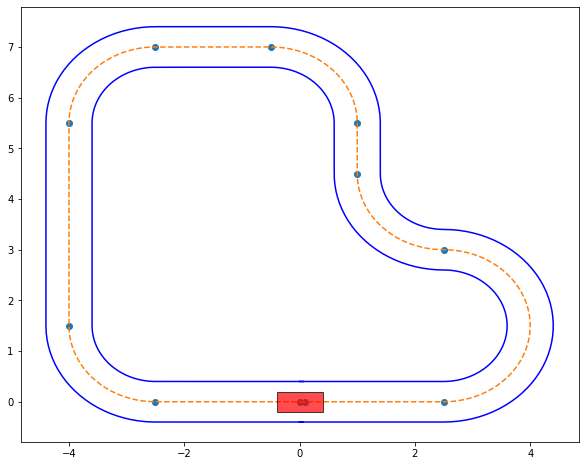

In [10]:
from vehicle_error import *
from vehicle_error import _initializeFigure_xy

In [260]:
data = np.dstack(data)

print (data)

[[[0.00000000e+00]
  [0.00000000e+00]
  [2.00400777e-05]
  ...
  [8.66382038e-01]
  [3.18930393e+00]
  [8.00677810e-01]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [9.99996191e-09]
  ...
  [3.96979000e+00]
  [4.83842874e+00]
  [5.54168206e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [7.99996953e-08]
  ...
  [3.08107724e+02]
  [3.10604885e+02]
  [3.13117260e+02]]

 [[0.00000000e+00]
  [2.00400802e-04]
  [6.01202405e-04]
  ...
  [2.48002004e+01]
  [2.49000000e+01]
  [2.50000000e+01]]]
